# Model Building
## Modeling Process Overview
### Data Preprocessing
- To properly address the conversion use case, the dataset was transformed such that each observation corresponds to a unique user, depicting their journey over the review period, rather than to a visit.
- After the initial data preprocessing and feature engineering, some variables were excluded due to their correlation with others and high cardinality.

### Class Distribution
- A significant class imbalance was observed in the dataset with a ratio of 99:1%. Consequently, most of the model tuning efforts were focused on addressing this imbalance.

### Data Splitting
- The data was split into training, testing, and validation sets using stratified sampling to account for class imbalance.

### Model Selection
- Logistic regression was chosen as the initial model due to the use case requirement to understand the influence of various factors on conversion. Additionally, other state-of-the-art ensemble techniques such as boosting, bagging, and stacking were explored.

### Model Tuning
- The primary techniques used to improve the model included threshold adjustment and the testing of a grid of class weights, mainly to address the issue of class imbalance.


In [46]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV, RandomizedSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import  precision_recall_curve, average_precision_score,f1_score, recall_score, precision_score,fbeta_score,make_scorer
from sklearn.metrics import roc_curve, roc_auc_score, ConfusionMatrixDisplay
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
from sklearn.feature_selection import RFE

from imblearn.combine import SMOTEENN
from imblearn.under_sampling import EditedNearestNeighbours, RandomUnderSampler
from collections import Counter
from scipy.stats import uniform


from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

import warnings
warnings.filterwarnings('ignore')

from sklearn.linear_model import LogisticRegression
import xgboost
from sklearn.ensemble import RandomForestClassifier, IsolationForest, StackingClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

from yellowbrick.model_selection import LearningCurve
from yellowbrick.classifier import ClassPredictionError





In [47]:
df=pd.read_csv('/Users/Abdul/Desktop/MMA/Enterprise Data Science/train_df.csv')
pd.set_option('display.max_columns', None)
df.head()


,fullVisitorId,FirstChannelVisit,LastChannelVisit,at_least_one_conversion,country,continent,subContinent,TotalVisits,TotalBounces,Organic Search,Social,Direct,Paid Search,Referral,Affiliates,Display,(Other),TotalPageviews,desktop,mobile,tablet,FirstSessionPageviews,LastSessionPageviews,CampaignVisits,isTrueDirect,AdContentVisits,Source_PC1,Source_PC2,Source_PC3
0,4823595352351,Organic Search,Organic Search,0,China,Asia,Eastern Asia,1,1,1,0,0,0,0,0,0,0,1,1,0,0,1,1,0,0,0,-0.406531,-0.073766,0.171027
1,5103959234087,Organic Search,Organic Search,0,United States,Americas,Northern America,1,0,1,0,0,0,0,0,0,0,8,0,1,0,8,8,0,0,0,0.569687,-0.098162,0.074920
2,10278554503158,Organic Search,Organic Search,0,New Zealand,Oceania,Australasia,1,0,1,0,0,0,0,0,0,0,8,1,0,0,8,8,0,0,0,0.569687,-0.098162,0.074920
3,20424342248747,Organic Search,Organic Search,0,Peru,Americas,South America,1,0,1,0,0,0,0,0,0,0,13,1,0,0,13,13,0,0,0,0.569687,-0.098162,0.074920
4,27376579751715,Organic Search,Organic Search,0,United States,Americas,Northern America,1,0,1,0,0,0,0,0,0,0,5,1,0,0,5,5,0,0,0,0.569687,-0.098162,0.074920


In [48]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 567490 entries, 0 to 567489
Data columns (total 29 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   fullVisitorId            567490 non-null  object 
 1   FirstChannelVisit        567490 non-null  object 
 2   LastChannelVisit         567490 non-null  object 
 3   at_least_one_conversion  567490 non-null  int64  
 4   country                  567490 non-null  object 
 5   continent                567490 non-null  object 
 6   subContinent             567490 non-null  object 
 7   TotalVisits              567490 non-null  int64  
 8   TotalBounces             567490 non-null  int64  
 9   Organic Search           567490 non-null  int64  
 10  Social                   567490 non-null  int64  
 11  Direct                   567490 non-null  int64  
 12  Paid Search              567490 non-null  int64  
 13  Referral                 567490 non-null  int64  
 14  Affi

In [49]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
at_least_one_conversion,567490.0,1.302226e-02,0.113370,0.000000,0.000000,0.000000,0.000000,1.000000
TotalVisits,567490.0,1.234094e+00,1.295159,1.000000,1.000000,1.000000,1.000000,228.000000
TotalBounces,567490.0,6.168849e-01,0.856224,0.000000,0.000000,1.000000,1.000000,171.000000
Organic Search,567490.0,4.820032e-01,0.967292,0.000000,0.000000,0.000000,1.000000,226.000000
Social,567490.0,3.728964e-01,0.599986,0.000000,0.000000,0.000000,1.000000,96.000000
Direct,567490.0,1.837354e-01,0.723757,0.000000,0.000000,0.000000,0.000000,119.000000
Paid Search,567490.0,3.186664e-02,0.318899,0.000000,0.000000,0.000000,0.000000,118.000000
Referral,567490.0,1.339689e-01,0.637561,0.000000,0.000000,0.000000,0.000000,104.000000
Affiliates,567490.0,2.102768e-02,0.198250,0.000000,0.000000,0.000000,0.000000,38.000000
Display,567490.0,8.394862e-03,0.168425,0.000000,0.000000,0.000000,0.000000,36.000000


In [50]:
df.columns

Index(['fullVisitorId', 'FirstChannelVisit', 'LastChannelVisit',
       'at_least_one_conversion', 'country', 'continent', 'subContinent',
       'TotalVisits', 'TotalBounces', 'Organic Search', 'Social', 'Direct',
       'Paid Search', 'Referral', 'Affiliates', 'Display', '(Other)',
       'TotalPageviews', 'desktop', 'mobile', 'tablet',
       'FirstSessionPageviews', 'LastSessionPageviews', 'CampaignVisits',
       'isTrueDirect', 'AdContentVisits', 'Source_PC1', 'Source_PC2',
       'Source_PC3'],
      dtype='object')

In [51]:
#df.drop(['fullVisitorId','country'],axis=1,inplace=True)

at_least_one_conversion
0    0.986978
1    0.013022
Name: proportion, dtype: float64


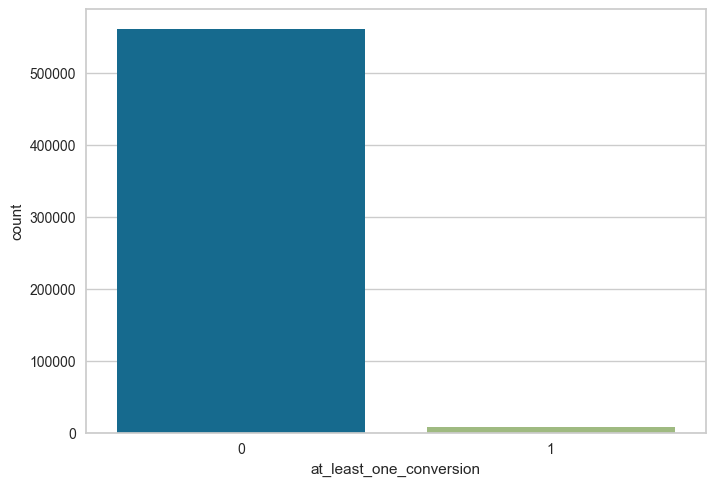

In [52]:
# Checking the class distribution of the target variable
print(df['at_least_one_conversion'].value_counts(normalize=True))
sns.countplot(x=df['at_least_one_conversion']);

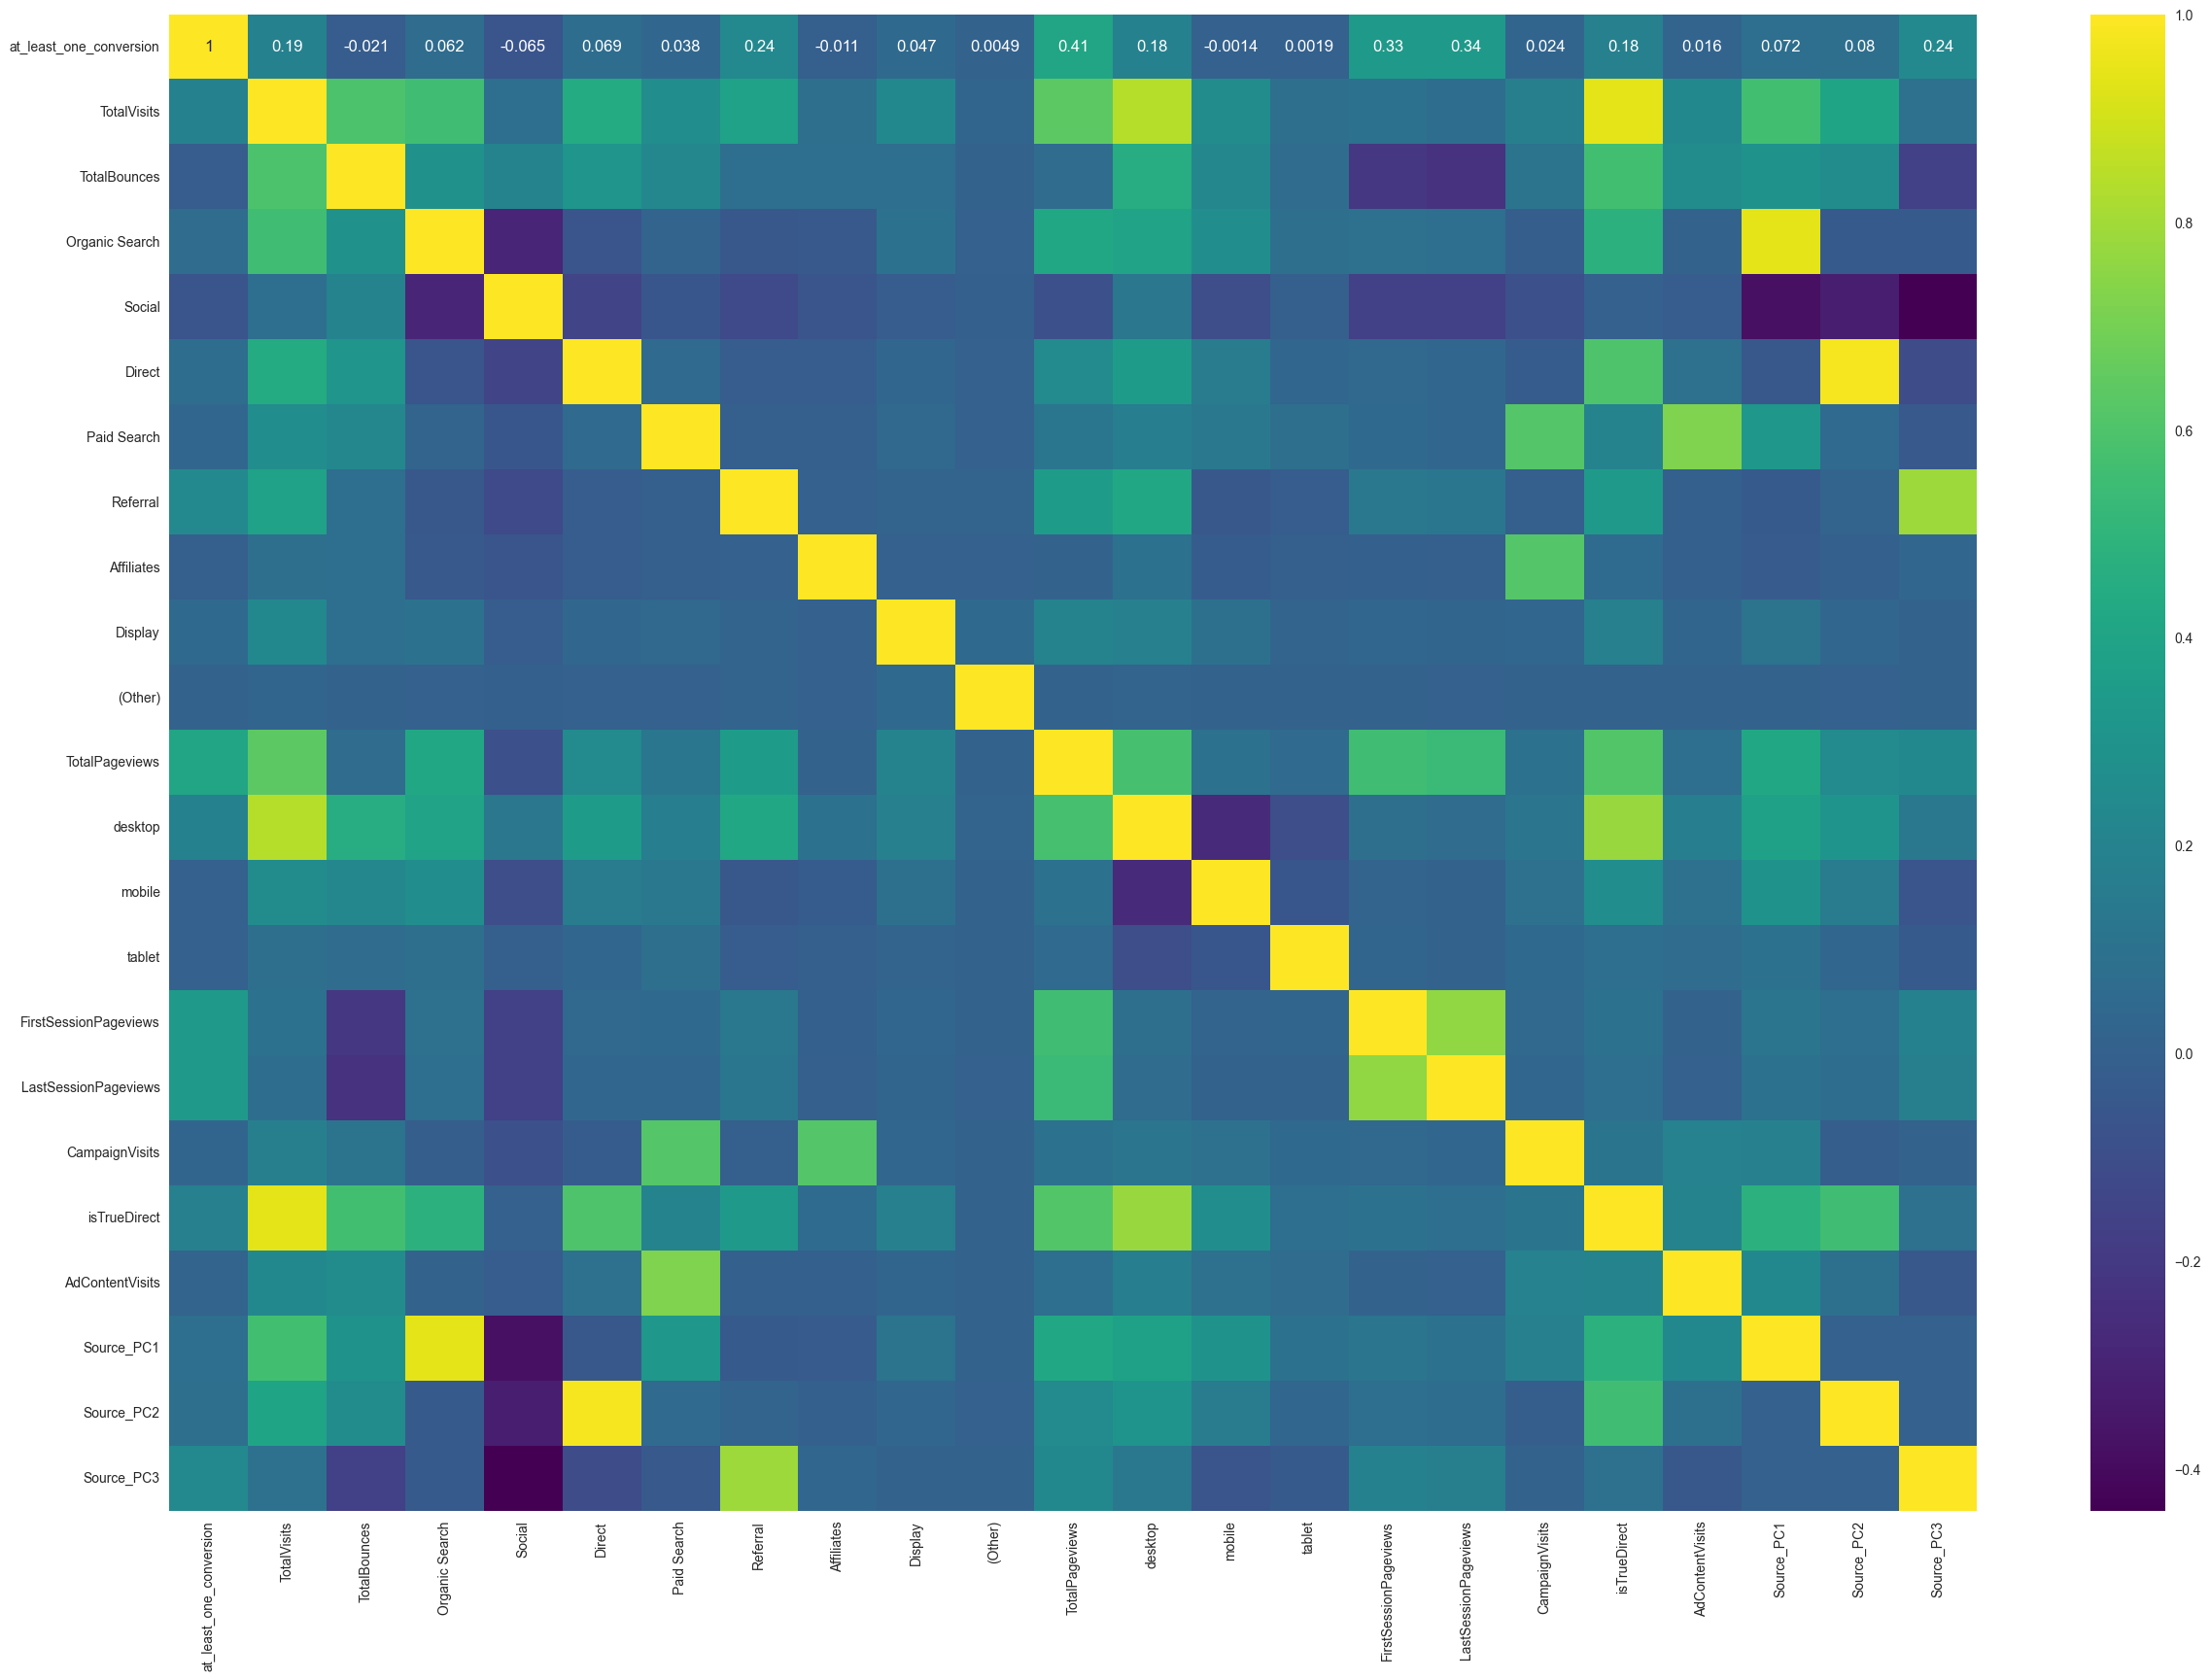

In [53]:
numeric_df = df.select_dtypes(include=['number'])
plt.figure(figsize=(30,20))
sns.heatmap(numeric_df.corr(),annot=True,cmap='viridis');

In [54]:
#numeric_df.corr()

# correlation gretaer than 0.5
correlation = numeric_df.corr()
correlation = correlation.abs().unstack()
correlation = correlation.sort_values(ascending=False)
correlation = correlation[correlation > 0.5]
correlation = correlation[correlation < 1]
correlation = pd.DataFrame(correlation).reset_index()
correlation.columns = ['feature1', 'feature2', 'correlation']

correlation



,feature1,feature2,correlation
0,Direct,Source_PC2,0.981939
1,Source_PC2,Direct,0.981939
2,TotalVisits,isTrueDirect,0.941050
3,isTrueDirect,TotalVisits,0.941050
4,Source_PC1,Organic Search,0.938208
5,Organic Search,Source_PC1,0.938208
6,desktop,TotalVisits,0.841147
7,TotalVisits,desktop,0.841147
8,Referral,Source_PC3,0.789788
9,Source_PC3,Referral,0.789788


In [55]:
# Dropping the highly correlated features and features that might lead to data leakage
#df.drop(['TotalVisits','LastSessionPageviews','TotalPageviews'],axis=1,inplace=True)

In [56]:
# cat_cols = df.select_dtypes(include='object').columns

# df=pd.get_dummies(df,columns=cat_cols,drop_first=True, dtype='int64')

In [57]:
df.shape

(567490, 29)

### Checking Outliers with Isolation Forest
- Many positive instances (minority class) were identified as outliers
- Will hold off on removing outliers in the interim

In [58]:
# isolation_forest = IsolationForest(random_state=42)
# outlier_pred = isolation_forest.fit_predict(df)
# outlier_pred


In [59]:
# # Removing the outlierrs.
# print("Number of rows without outliers:", len(df[outlier_pred == 1]))
# df_inliers = df.iloc[outlier_pred == 1]

# print("New shape:", df.shape)
# df_inliers.at_least_one_conversion.value_counts(normalize=True)


In [60]:
# def preprocess_data(df):
#     df.drop(['fullVisitorId','country','TotalVisits','LastSessionPageviews','TotalPageviews'],axis=1,inplace=True)
#     cat_cols = df.select_dtypes(include='object').columns
#     df=pd.get_dummies(df,columns=cat_cols,drop_first=True, dtype='int64')
#     # isolation_forest = IsolationForest(random_state=42)
#     # outlier_pred = isolation_forest.fit_predict(df)
#     # df_inliers = df.iloc[outlier_pred == 1]
#     X=df.drop('at_least_one_conversion',axis=1)
#     y=df['at_least_one_conversion']
#     return X, y


In [61]:
def preprocess_data(df, country_categories, pca_model=None, kmeans_model=None, fit_pca=True, fit_kmeans=True):
    # Validate presence of 'fullVisitorId'
    if 'fullVisitorId' not in df.columns:
        raise KeyError("DataFrame must include 'fullVisitorId' column.")

    # Calculate User Engagement Depth
    df['UserEngagementDepth'] = df['TotalPageviews'] / df['TotalVisits']
    df['UserEngagementDepth'].replace([float('inf'), -float('inf'), float('nan')], 0, inplace=True)
    
    # Standardize select features for clustering to improve performance
    features_for_clustering = ['TotalPageviews', 'TotalVisits', 'UserEngagementDepth', 'desktop', 'mobile', 'tablet']
    scaler = StandardScaler()
    scaled_features = scaler.fit_transform(df[features_for_clustering])
    
    # Perform clustering
    if fit_kmeans:
        kmeans_model = KMeans(n_clusters=3, random_state=42)
        clusters = kmeans_model.fit_predict(scaled_features)
    else:
        clusters = kmeans_model.predict(scaled_features)
    df['ClusterLabel'] = clusters
    
    # One-hot encode 'country' and reindex with all possible categories to ensure consistency
    country_encoded = pd.get_dummies(df['country'], prefix='country')
    country_encoded = country_encoded.reindex(columns=['country_' + c for c in country_categories], fill_value=0)
    
    if fit_pca:
        pca_model = PCA(n_components=3)
        country_pca = pca_model.fit_transform(country_encoded)
    else:
        country_pca = pca_model.transform(country_encoded)
    
    country_pca_df = pd.DataFrame(country_pca, columns=['country_PC1', 'country_PC2', 'country_PC3'])
    
    # Merge PCA data back, ensure 'fullVisitorId' is available for any needed operations
    country_pca_df['fullVisitorId'] = df['fullVisitorId'].values
    df = pd.merge(df, country_pca_df, on='fullVisitorId', how='inner')

    # Now you can safely drop 'fullVisitorId' and other specified columns
    df.drop(['fullVisitorId', 'country', 'TotalVisits', 'LastSessionPageviews', 'TotalPageviews'], axis=1, inplace=True)
    
    # Handle other categorical columns
    cat_cols = df.select_dtypes(include='object').columns
    df = pd.get_dummies(df, columns=cat_cols, drop_first=True, dtype='int64')
    
    X = df.drop('at_least_one_conversion', axis=1)
    y = df['at_least_one_conversion']
    
    return X, y, pca_model, kmeans_model


### Splitting the dataset into train, test, and validation sets
- Chose stratified sampling to maintain class distribution

In [62]:
# Split the data into training and validation sets directly
df_train, df_val = train_test_split(df, test_size=0.15, random_state=42, stratify=df['at_least_one_conversion'])


In [63]:
country_categories = df['country'].unique().tolist()

In [64]:
# Preprocess the training data; assuming preprocess_data is modified to fit models
X_train, y_train, pca_train, kmeans_train = preprocess_data(df_train, country_categories, fit_pca=True, fit_kmeans=True)


In [66]:
# Preprocess the validation data using the existing PCA and KMeans models
X_val, y_val, _, _ = preprocess_data(df_val, country_categories, pca_model=pca_train, kmeans_model=kmeans_train, fit_pca=False, fit_kmeans=False)


In [67]:
def plot_roc_curve(fpr, tpr, roc_auc):
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

In [68]:
def plot_pr_curve(precision, recall, average_precision):
    plt.step(recall, precision, color='b', alpha=0.2, where='post')
    plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')   
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(average_precision))
    plt.show()

In [69]:
from matplotlib.colors import ListedColormap
def clf_score(clf, X_train, y_train, X_val, y_val, train=True):
    if train:
        predictions_train = clf.predict(X_train)
        print("Train Result:\n")
        print(f"accuracy score: {accuracy_score(y_train, predictions_train):.4f}\n")
        print(f"Classification Report: \n {classification_report(y_train, predictions_train)}\n")
        print(f"Confusion Matrix: \n {confusion_matrix(y_train, predictions_train)}\n")

        res = cross_val_score(clf, X_train, y_train, cv=10, scoring='accuracy')
        print(f"Average Accuracy: \t {np.mean(res):.4f}")
        print(f"Accuracy SD: \t\t {np.std(res):.4f}")

    else:
        predictions_val = clf.predict(X_val)
        probas_val = clf.predict_proba(X_val)[:, 1]  
        precision, recall, _ = precision_recall_curve(y_val, probas_val)
        average_precision = average_precision_score(y_val, probas_val)
        plot_pr_curve(precision, recall, average_precision)

        fpr, tpr, _ = roc_curve(y_val, probas_val)
        roc_auc = roc_auc_score(y_val, probas_val)
        print(f"roc auc score: {roc_auc}\n")
        plot_roc_curve(fpr, tpr, roc_auc)

        print(f"Classification Report: \n {classification_report(y_val, predictions_val)}\n")
        print(f"Confusion Matrix: \n {confusion_matrix(y_val, predictions_val)}\n")
        ConfusionMatrixDisplay.from_estimator(clf, X_val, y_val).im_.set_cmap(ListedColormap(['#34a853', '#4285f4', '#fbbb07']))
        plt.show()
        print("End of validation Result\n")


### Baseline Model

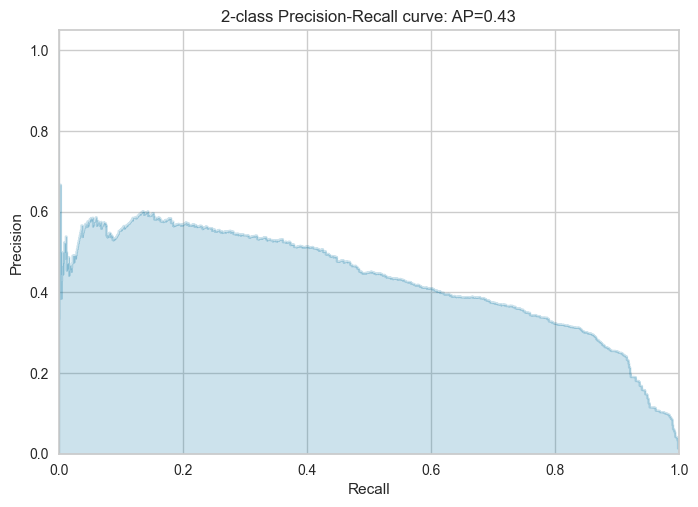

roc auc score: 0.9813924889564827



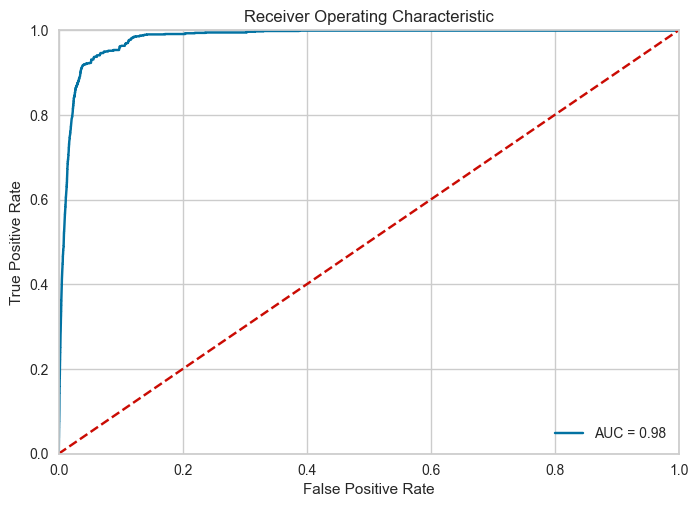

Classification Report: 
               precision    recall  f1-score   support

           0       0.99      1.00      0.99     84092
           1       0.59      0.14      0.23      1114

    accuracy                           0.99     85206
   macro avg       0.79      0.57      0.61     85206
weighted avg       0.98      0.99      0.98     85206


Confusion Matrix: 
 [[83980   112]
 [  953   161]]



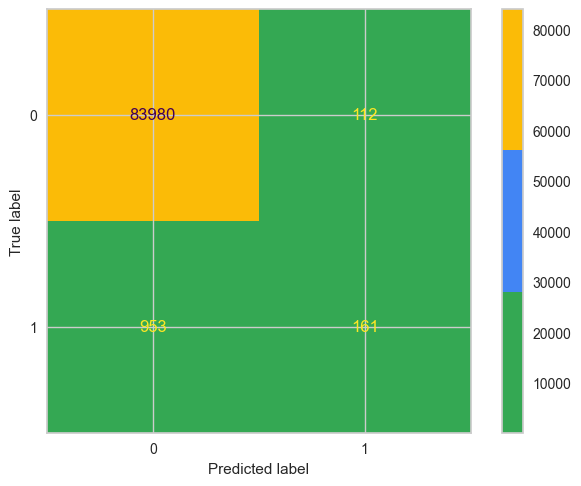

End of validation Result



In [70]:
logreg=LogisticRegression(max_iter=2000,random_state=42)
logreg.fit(X_train, y_train)
clf_score(logreg, X_train, y_train, X_val, y_val, train=False)

# Setting Class weight to balanced

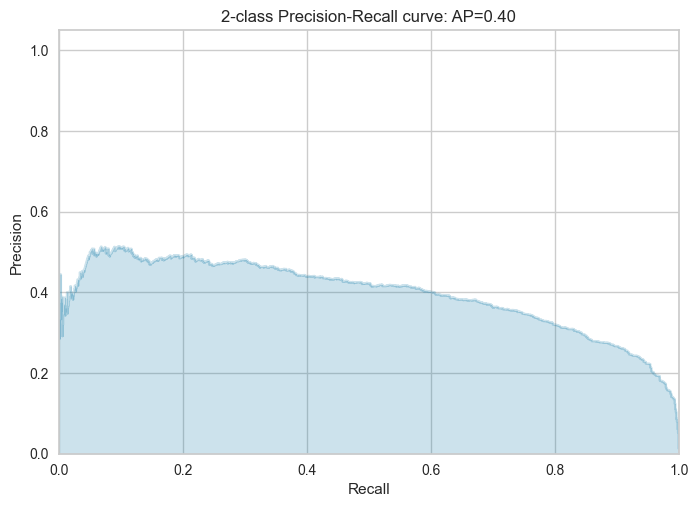

roc auc score: 0.9855292871507491



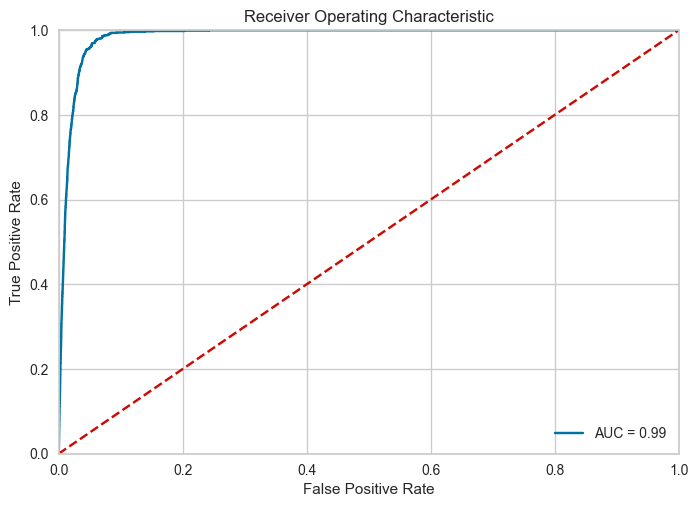

Classification Report: 
               precision    recall  f1-score   support

           0       1.00      0.95      0.97     84092
           1       0.20      0.96      0.33      1114

    accuracy                           0.95     85206
   macro avg       0.60      0.95      0.65     85206
weighted avg       0.99      0.95      0.96     85206


Confusion Matrix: 
 [[79730  4362]
 [   43  1071]]



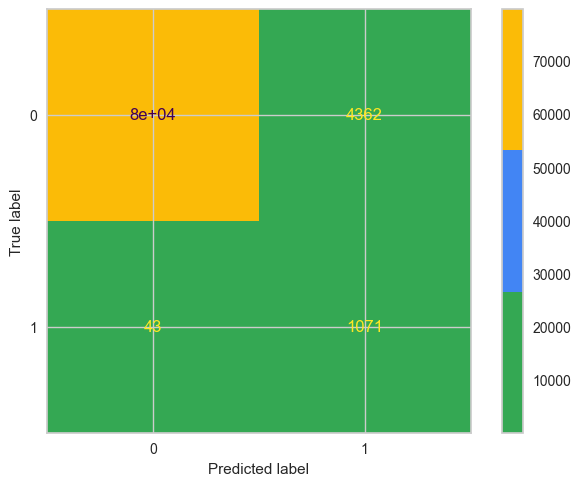

End of validation Result



In [71]:
logreg2=LogisticRegression(max_iter=2000, class_weight='balanced',random_state=42)
logreg2.fit(X_train, y_train)
clf_score(logreg2, X_train, y_train, X_val, y_val, train=False)


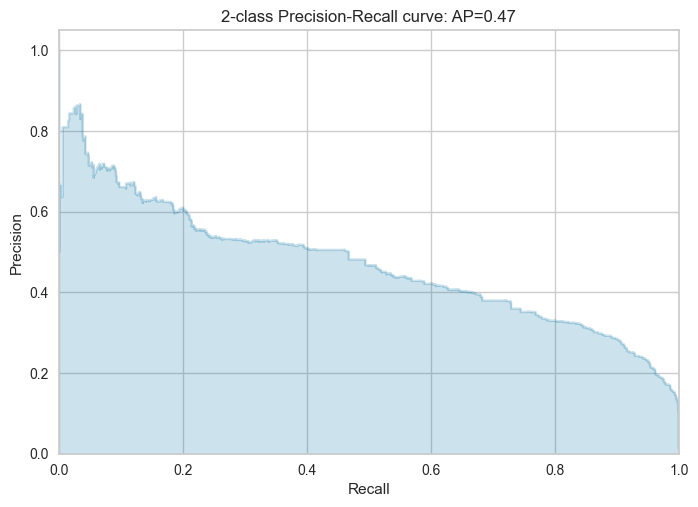

roc auc score: 0.9872278361281834



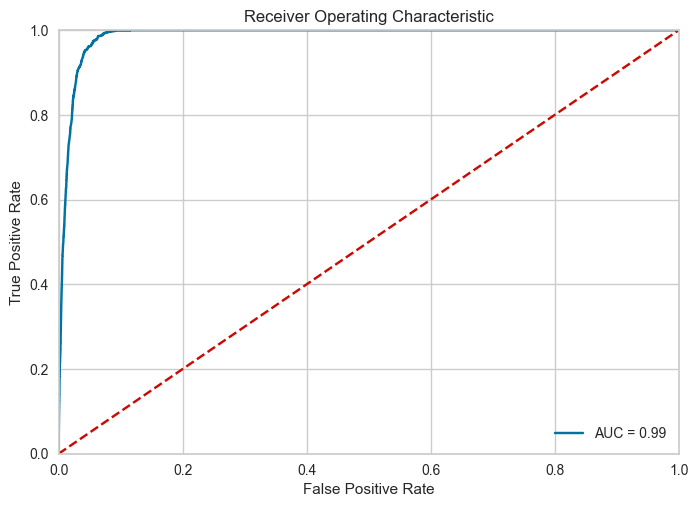

Classification Report: 
               precision    recall  f1-score   support

           0       1.00      0.94      0.97     84092
           1       0.17      0.99      0.29      1114

    accuracy                           0.94     85206
   macro avg       0.58      0.96      0.63     85206
weighted avg       0.99      0.94      0.96     85206


Confusion Matrix: 
 [[78675  5417]
 [   16  1098]]



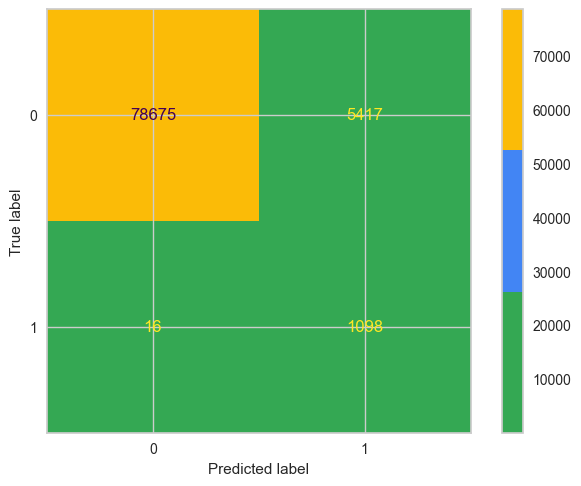

End of validation Result



In [72]:
rf_model=RandomForestClassifier(n_estimators=100,max_depth=5, random_state=42, class_weight='balanced')
rf_model.fit(X_train, y_train)
clf_score(rf_model, X_train, y_train, X_val, y_val, train=False)

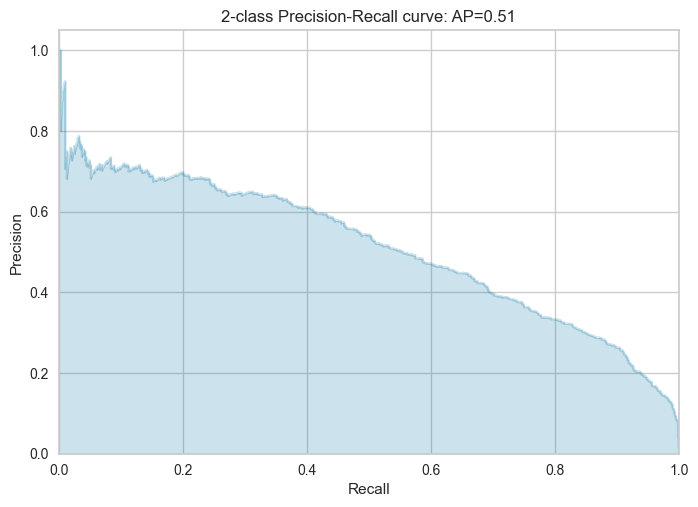

roc auc score: 0.9863221532781358



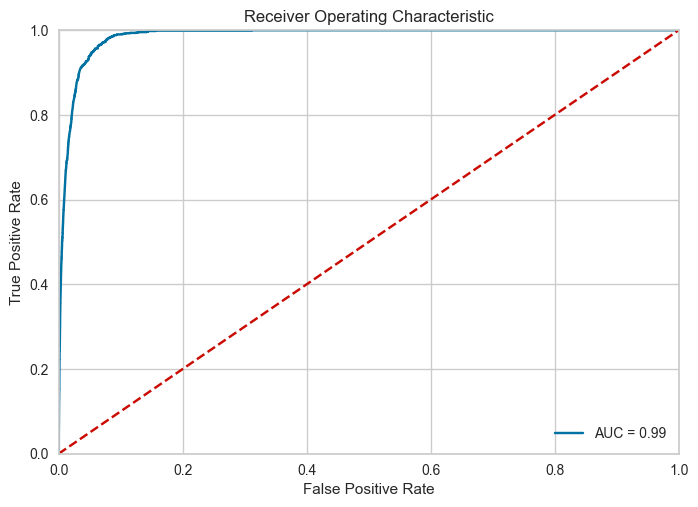

Classification Report: 
               precision    recall  f1-score   support

           0       1.00      0.96      0.98     84092
           1       0.22      0.92      0.35      1114

    accuracy                           0.96     85206
   macro avg       0.61      0.94      0.67     85206
weighted avg       0.99      0.96      0.97     85206


Confusion Matrix: 
 [[80418  3674]
 [   84  1030]]



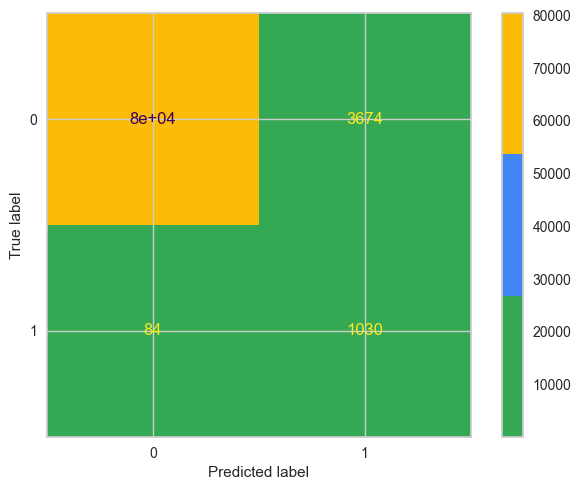

End of validation Result



In [73]:
scale_pos_weight = y_train.value_counts()[0] / y_train.value_counts()[1]
xgb_model=xgboost.XGBClassifier(n_estimators=300, max_depth=5, random_state=42,scale_pos_weight=scale_pos_weight)
xgb_model.fit(X_train, y_train)
clf_score(xgb_model, X_train, y_train, X_val, y_val, train=False)

### Feature Selection Using Random Forest and RFE

In [74]:
# getting the feature importance from the random forest model   
feature_importances = pd.DataFrame(rf_model.feature_importances_, index = X_train.columns, columns=['importance']).sort_values('importance', ascending=False)
feature_importances.head(20)

,importance
UserEngagementDepth,0.282502
ClusterLabel,0.160181
FirstSessionPageviews,0.115417
country_PC1,0.054756
continent_Americas,0.052171
subContinent_Northern America,0.042150
desktop,0.040008
isTrueDirect,0.038211
Source_PC3,0.030911
country_PC3,0.027682


Text(0.5, 1.0, 'Feature Importance')

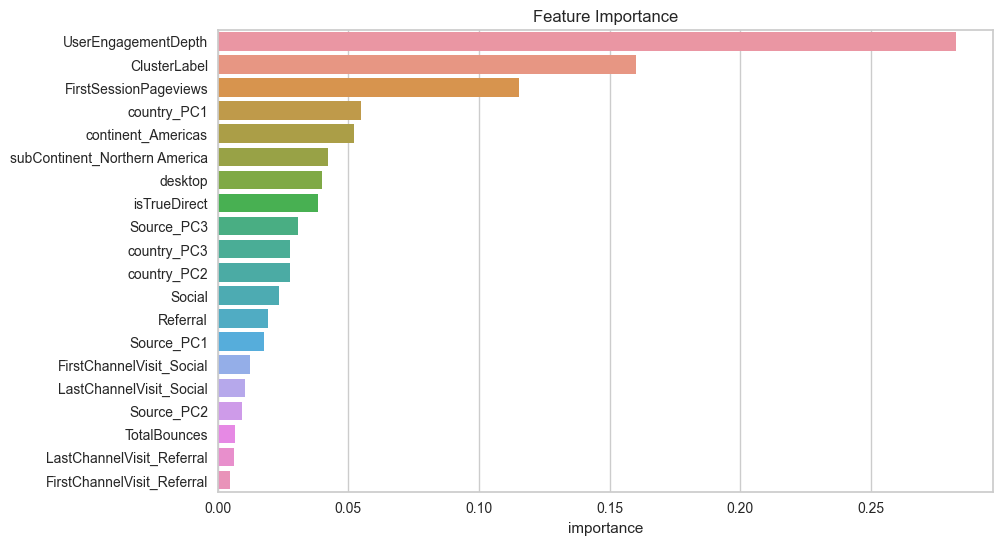

In [75]:
#plotting the top 20 features
plt.figure(figsize=(10, 6)) 
sns.barplot(x=feature_importances['importance'][:20], y=feature_importances.index[:20]);
plt.title('Feature Importance')


In [76]:
# Using the top 20 features from the random forest model
top_features = feature_importances.index[:20]
X_train_top = X_train[top_features]
X_val_top = X_val[top_features]


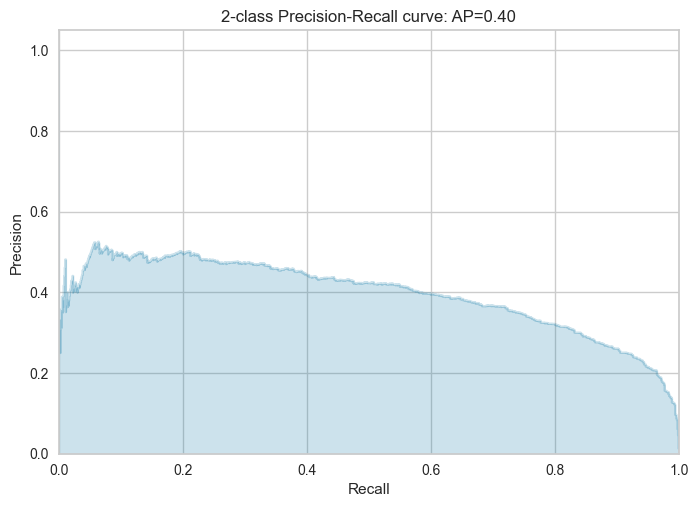

roc auc score: 0.9852915324594052



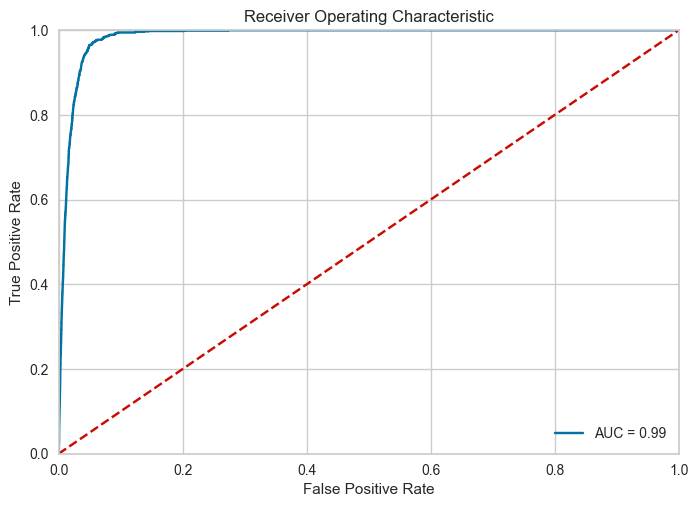

Classification Report: 
               precision    recall  f1-score   support

           0       1.00      0.95      0.97     84092
           1       0.20      0.97      0.33      1114

    accuracy                           0.95     85206
   macro avg       0.60      0.96      0.65     85206
weighted avg       0.99      0.95      0.96     85206


Confusion Matrix: 
 [[79667  4425]
 [   38  1076]]



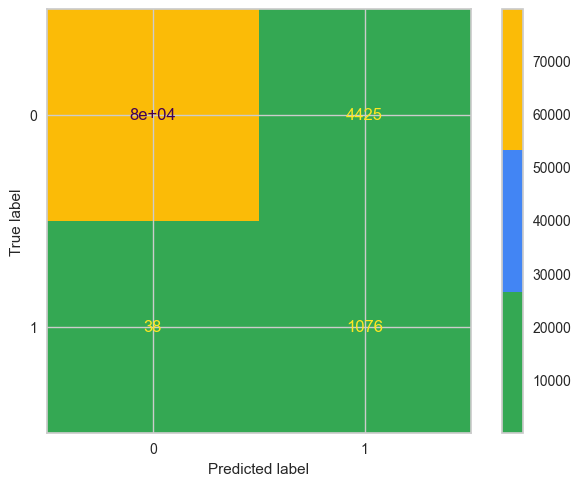

End of validation Result



In [77]:
logreg3=LogisticRegression(max_iter=2000,random_state=42, class_weight='balanced')
logreg3.fit(X_train_top, y_train)
clf_score(logreg3, X_train_top, y_train, X_val_top, y_val, train=False)

### Logistic Regression with Inliers
- Worse performance given more pronounced class imbalance

In [ ]:
X_inlier=df_inliers.drop('at_least_one_conversion',axis=1)
y_inlier=df_inliers['at_least_one_conversion']

In [ ]:
X_train_inlier, X_test_inlier, y_train_inlier, y_test_inlier = train_test_split(X_inlier, y_inlier, test_size=0.30, random_state=42)

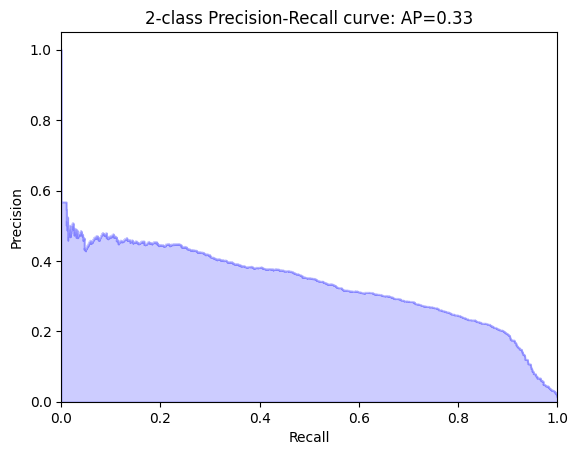

roc auc score: 0.9669528972877929



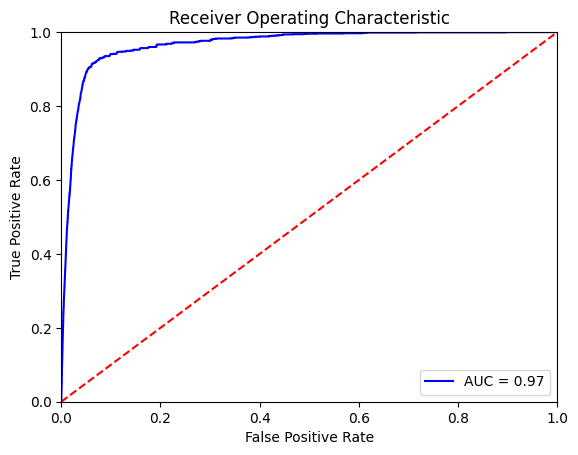

Classification Report: 
               precision    recall  f1-score   support

           0       1.00      0.93      0.96    114191
           1       0.16      0.92      0.27      1618

    accuracy                           0.93    115809
   macro avg       0.58      0.92      0.62    115809
weighted avg       0.99      0.93      0.95    115809


Confusion Matrix: 
 [[106309   7882]
 [   132   1486]]



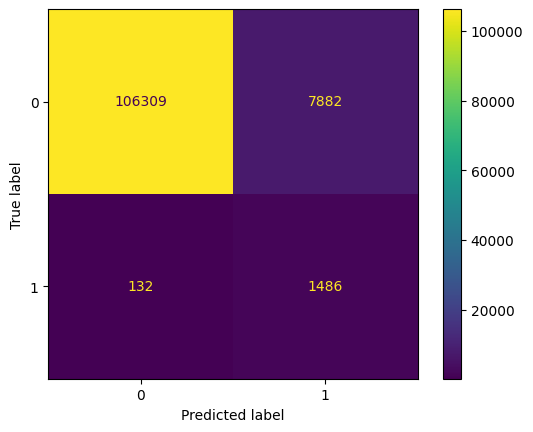

End of validation Result



In [ ]:
logreg4=LogisticRegression(max_iter=2000,random_state=42, class_weight='balanced')
logreg4.fit(X_train_inlier, y_train_inlier)
clf_score(logreg4, X_train_inlier, y_train_inlier, X_val, y_val, train=False)

In [ ]:
# param_distributions = {
#     'C': uniform(0.01, 10),
    
# }

# random_search = RandomizedSearchCV(
#     estimator=logreg3,
#     param_distributions=param_distributions,
#     scoring='precision',  
#     cv=5,
#     random_state=42,
#     n_jobs=-1,
#     verbose=1
# )

# random_search.fit(X_train_top, y_train)

# print("Best hyperparameters: ", random_search.best_params_)


# clf_score(random_search.best_estimator_, X_train_top, y_train, X_test_top, y_test, train=False)


### Threshold Moving to Handle Class Imbalance

In [78]:
# Defining a function to find the optimal threshold for a model
def find_optimal_threshold(clf, X, y, beta=1, n_splits=5):
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    best_fbeta_avg = 0
    best_threshold = 0.5
    clf.fit(X, y)

    for threshold in np.arange(0.01, 1, 0.01):
        fbeta_scores = []
        
        for train_index, val_index in skf.split(X, y):
            X_train, X_val = X.iloc[train_index], X.iloc[val_index]
            y_train, y_val = y.iloc[train_index], y.iloc[val_index]
            
            probas_val = clf.predict_proba(X_val)[:, 1]
            predictions = (probas_val >= threshold).astype(int)
            fbeta = fbeta_score(y_val, predictions, beta=beta)
            fbeta_scores.append(fbeta)
        
        fbeta_avg = np.mean(fbeta_scores)
        if fbeta_avg > best_fbeta_avg:
            best_fbeta_avg = fbeta_avg
            best_threshold = threshold
            
    return best_threshold, best_fbeta_avg


In [80]:
# defining a function to get the classification report and confusion matrix of a classifier with a given threshold
def clf_score_th(clf, X_train, y_train, X_val, y_val, train=True, threshold=0.5):  
    if train:
        predictions_train = clf.predict(X_train)
        print("Train Result:\n")
        print(f"accuracy score: {accuracy_score(y_train, predictions_train):.4f}\n")
        print(f"Classification Report: \n {classification_report(y_train, predictions_train)}\n")
        print(f"Confusion Matrix: \n {confusion_matrix(y_train, predictions_train)}\n")

        res = cross_val_score(clf, X_train, y_train, cv=10, scoring='accuracy')
        print(f"Average Accuracy: \t {np.mean(res):.4f}")
        print(f"Accuracy SD: \t\t {np.std(res):.4f}")
    else:
        probas_val = clf.predict_proba(X_val)[:, 1]
        predictions_val = (probas_val >= threshold).astype(int) 

        precision, recall, _ = precision_recall_curve(y_val, probas_val)
        average_precision = average_precision_score(y_val, probas_val)
        plot_pr_curve(precision, recall, average_precision)

        fpr, tpr, _ = roc_curve(y_val, probas_val)
        roc_auc = roc_auc_score(y_val, probas_val)
        print(f"roc auc score: {roc_auc}\n")
        plot_roc_curve(fpr, tpr, roc_auc)

        print(f"Classification Report: \n {classification_report(y_val, predictions_val)}\n")
        print(f"Confusion Matrix: \n {confusion_matrix(y_val, predictions_val)}\n")
        ConfusionMatrixDisplay.from_estimator(clf, X_val, y_val).im_.set_cmap(ListedColormap(['#34a853', '#4285f4', '#fbbb07']))
        plt.show()
        print("End of validation Result\n")

In [81]:
logreg5=LogisticRegression(max_iter=2000,random_state=42,C=0.0001,class_weight='balanced')
optimal_threshold, optimal_f1 = find_optimal_threshold(logreg5, X_train_top, y_train)
print(f"Optimal Threshold: {optimal_threshold:.2f}")
print(f"Optimal F1 Score: {optimal_f1:.4f}")


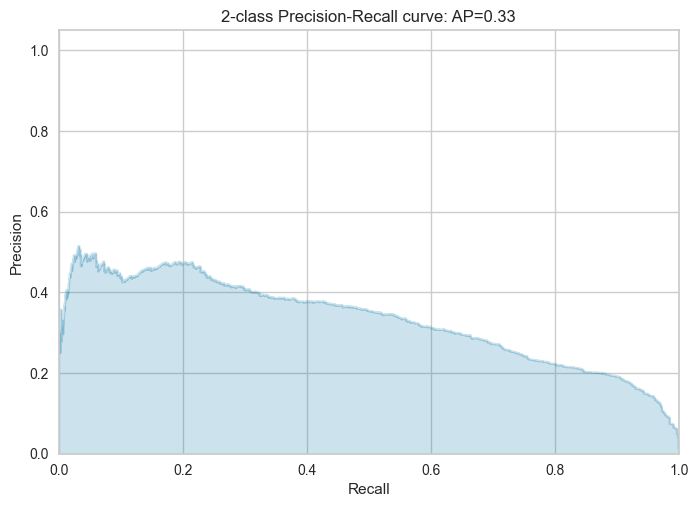

roc auc score: 0.9773524597646079



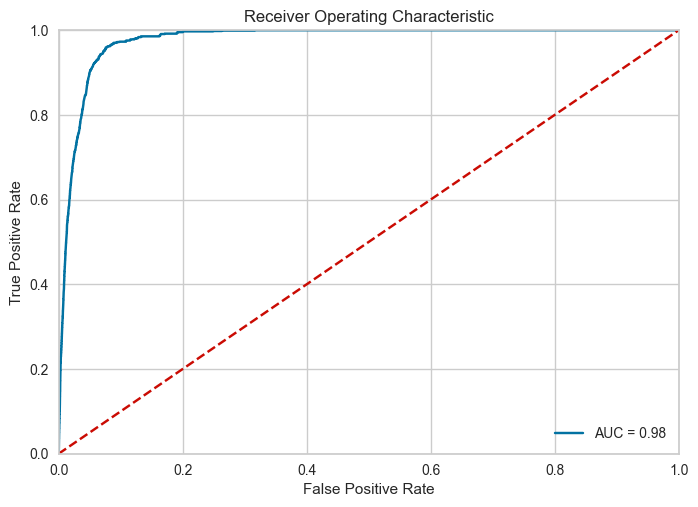

Classification Report: 
               precision    recall  f1-score   support

           0       0.99      0.99      0.99     84015
           1       0.34      0.55      0.42      1109

    accuracy                           0.98     85124
   macro avg       0.67      0.77      0.70     85124
weighted avg       0.99      0.98      0.98     85124


Confusion Matrix: 
 [[82827  1188]
 [  502   607]]



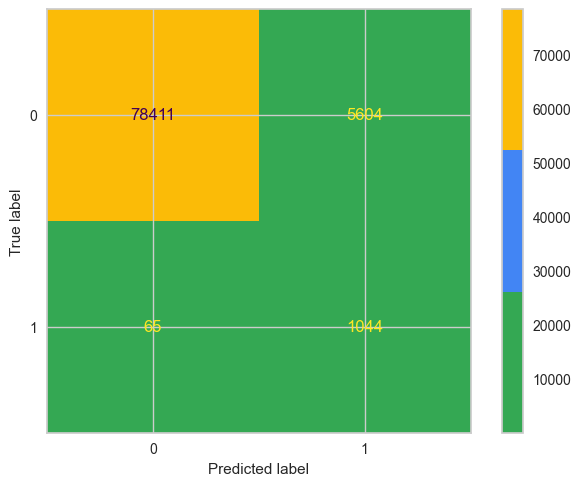

End of validation Result



In [33]:
clf_score_th(logreg5, X_train_top, y_train, X_val_top, y_val, train=False, threshold=optimal_threshold)

In [ ]:
# For F0.5 score
optimal_threshold_f05, optimal_f05 = find_optimal_threshold(logreg5, X_train_top, y_train, beta=0.5)
print(f"Optimal Threshold for F0.5: {optimal_threshold_f05:.2f}")
print(f"Optimal F0.5 Score: {optimal_f05:.4f}")

# For F2 score
optimal_threshold_f2, optimal_f2 = find_optimal_threshold(logreg5, X_train_top, y_train, beta=2)
print(f"Optimal Threshold for F2: {optimal_threshold_f2:.2f}")
print(f"Optimal F2 Score: {optimal_f2:.4f}")


Optimal Threshold for F0.5: 0.98
Optimal F0.5 Score: 0.3789
Optimal Threshold for F2: 0.74
Optimal F2 Score: 0.5370


In [ ]:
clf_score_th(logreg5, X_train_top, y_train, X_val_top, y_val, train=False, threshold=optimal_threshold_f05)

In [ ]:
clf_score_th(logreg5, X_train_top, y_train, X_val_top, y_val, train=False, threshold=optimal_threshold_f2)

## Printing Coefficients from the logistic regression model

In [ ]:

Results=pd.DataFrame(logreg5.coef_, columns=X_train_top.columns).T
Results.columns = ['Coefficient']

Results

,0
FirstSessionPageviews,0.188380
desktop,0.622271
subContinent_Northern America,0.589157
Referral,0.447140
continent_Americas,0.493473
LastChannelVisit_Referral,0.201491
FirstChannelVisit_Referral,0.115872
Organic Search,0.334647
TotalBounces,-0.385062
continent_Europe,-0.234166


### Implementing Stacking Ensemble

In [35]:
# selecting two base learners for the stacking classifier
base_learners = [
    ('rf_model', RandomForestClassifier(n_estimators=100,max_depth=5, random_state=42, class_weight={0: 1, 1: 10})),
    ('xgb_model', xgboost.XGBClassifier(n_estimators=300, max_depth=5, learning_rate=0.2, random_state=42)),
    ('logreg5', LogisticRegression(max_iter=2000,random_state=42,class_weight={0: 1, 1: 8})),
    ('AdaBoost', AdaBoostClassifier(n_estimators=100, random_state=42)),
    ('D_tree', DecisionTreeClassifier(max_depth=5, random_state=42))
]

In [36]:
meta_learner = LogisticRegression(max_iter=2000,random_state=42, class_weight={0: 1, 1: 8})

In [37]:
# instantiating the stacking classifier
model=StackingClassifier(estimators=base_learners, final_estimator=meta_learner, cv=5,stack_method='auto')    

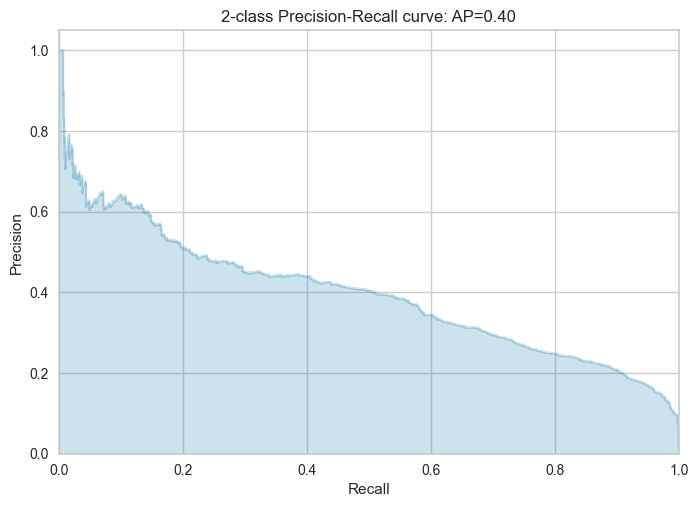

roc auc score: 0.9815283478888409



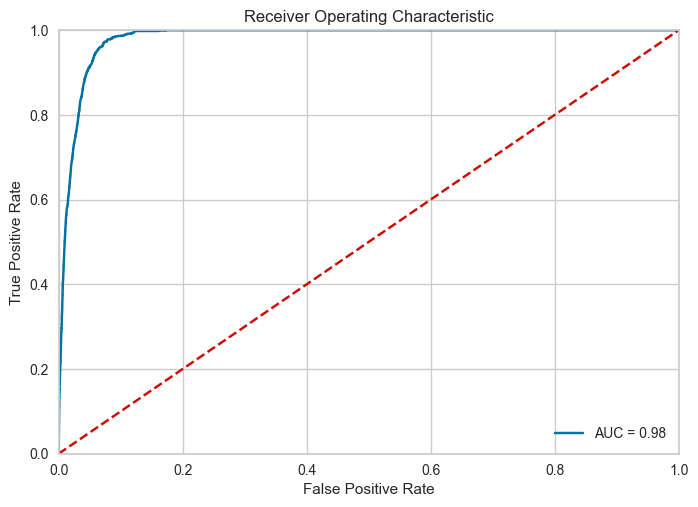

Classification Report: 
               precision    recall  f1-score   support

           0       1.00      0.98      0.99     84015
           1       0.29      0.71      0.41      1109

    accuracy                           0.97     85124
   macro avg       0.64      0.84      0.70     85124
weighted avg       0.99      0.97      0.98     85124


Confusion Matrix: 
 [[82088  1927]
 [  324   785]]



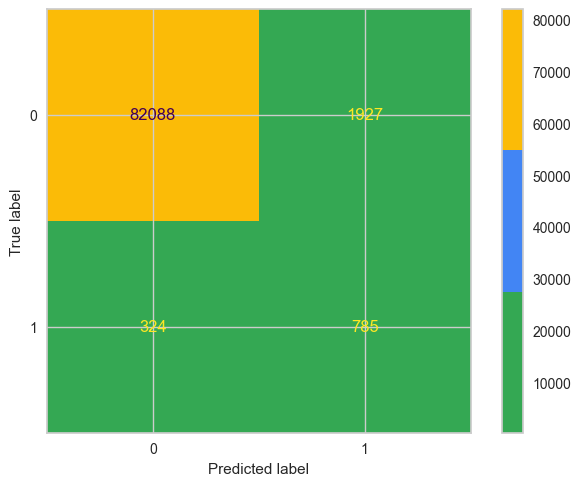

End of validation Result



In [38]:
# fitting the model
model.fit(X_train_top, y_train)
clf_score(model, X_train_top, y_train, X_val_top, y_val, train=False)

In [39]:
# getting the optimal threshold for the stacking model
optimal_th, optimal_f1=find_optimal_threshold(model, X_train_top, y_train,beta=1)
print(f"Optimal Threshold for F1: {optimal_th:.2f}")
print(f"Optimal F1 Score: {optimal_f1:.4f}")

Optimal Threshold for F1: 0.74


NameError: name 'optimal_f05' is not defined

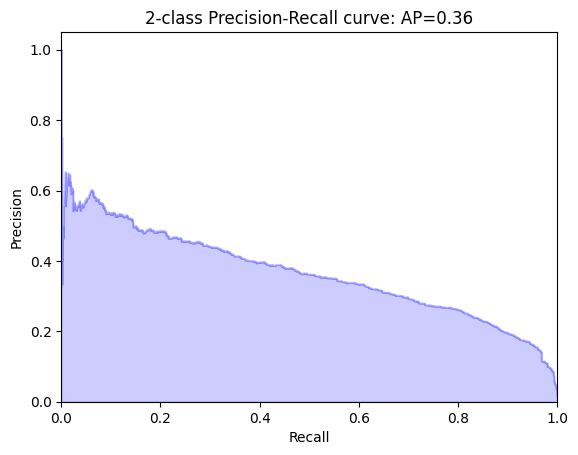

roc auc score: 0.9776671935562519



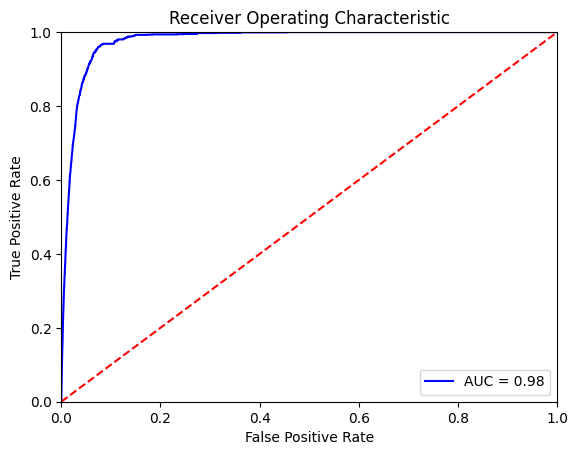

Classification Report: 
               precision    recall  f1-score   support

           0       0.99      0.99      0.99    114191
           1       0.35      0.56      0.43      1618

    accuracy                           0.98    115809
   macro avg       0.67      0.77      0.71    115809
weighted avg       0.98      0.98      0.98    115809


Confusion Matrix: 
 [[112517   1674]
 [   720    898]]



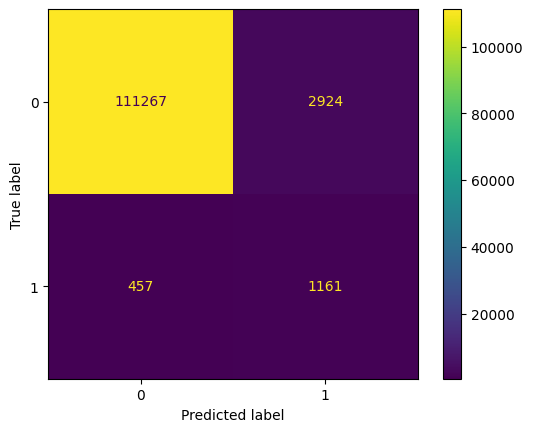

End of validation Result



In [ ]:
# evaluating the model with the optimal threshold
clf_score_th(model, X_train_top, y_train, X_val_top, y_val, train=False, threshold=optimal_th) 

In [ ]:
# classifier = LogisticRegression(max_iter=2000,random_state=42)

# # Define your grid of class weights
# # Suppose you have two classes: 0 and 1
# class_weights = [
#     {0: 1, 1: 3},
#     {0: 1, 1: 50},
#     {0: 1, 1: 100},
#     {0: 1, 1: 4}

# ]

# # Define parameter grid
# param_grid = {'class_weight': class_weights}

# # Define scorer, for example, F1
# scorer = make_scorer(f1_score)

# # Setup the grid search
# grid_search = GridSearchCV(classifier, param_grid, scoring=scorer, cv=5, verbose=1)

# # Fit the grid search to the data
# grid_search.fit(X_train_top, y_train)

# print("Best class weights:", grid_search.best_params_)


Fitting 5 folds for each of 4 candidates, totalling 20 fits
Best class weights: {'class_weight': {0: 1, 1: 4}}


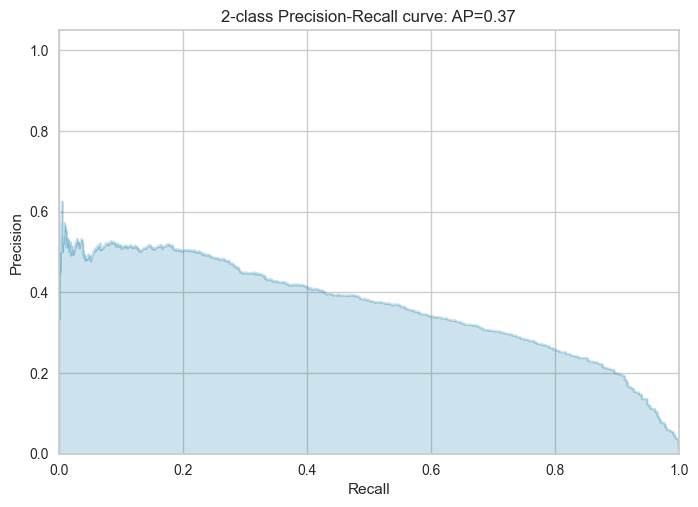

roc auc score: 0.9747510592574177



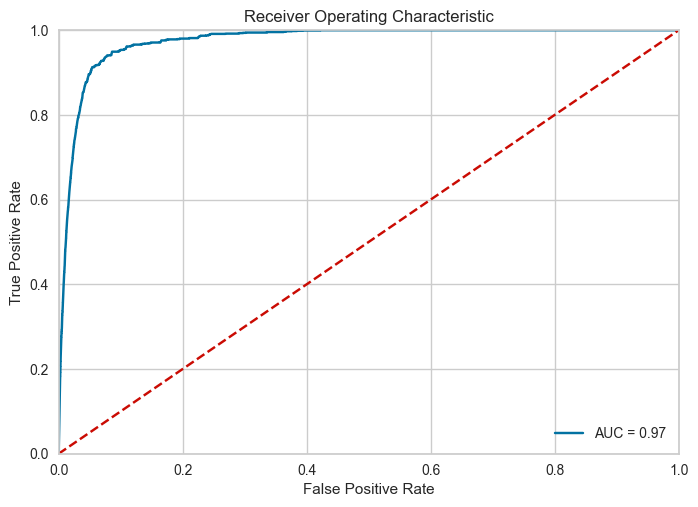

Classification Report: 
               precision    recall  f1-score   support

           0       0.99      0.98      0.99    114191
           1       0.34      0.61      0.44      1618

    accuracy                           0.98    115809
   macro avg       0.67      0.80      0.71    115809
weighted avg       0.99      0.98      0.98    115809


Confusion Matrix: 
 [[112261   1930]
 [   631    987]]



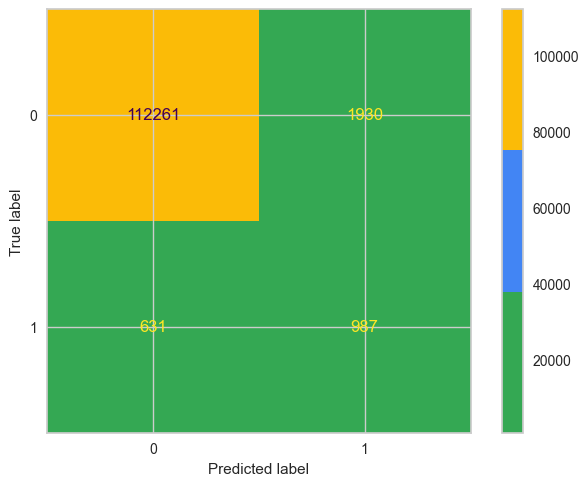

End of validation Result



In [ ]:
# training the model with the best class weights obtained from the grid search commented out above and experimentations
logreg_custom_w=LogisticRegression(max_iter=2000,random_state=42,class_weight={0: 1, 1: 8})
logreg_custom_w.fit(X_train_top, y_train)
# Getting the model vaidation results
clf_score(logreg_custom_w, X_train_top, y_train, X_val_top, y_val, train=False)


### Coefficients of the Best Performing Model
- The  best performing model is the logistic regression model with the class weights of 1 and 8 for the negative and positive classes respectively

In [ ]:
Results_final=pd.DataFrame(logreg_custom_w.coef_, columns=X_train_top.columns).T
Results_final.columns = ['Coefficient']

Results_final

# print in order of absolute value of coefficient
Results_final['abs_coef'] = abs(Results_final['Coefficient'])
Results_final.sort_values(by='abs_coef', ascending=False, inplace=True)
Results_final.drop('abs_coef', axis=1, inplace=True)
Results_final

,Coefficient
subContinent_Northern America,2.094998
continent_Americas,1.495318
subContinent_Southern Asia,-1.300933
FirstChannelVisit_Social,-1.102428
TotalBounces,-0.949972
LastChannelVisit_Referral,0.915346
LastChannelVisit_Social,-0.757257
FirstChannelVisit_Organic Search,-0.729678
continent_Asia,0.630254
Organic Search,0.626897


### Probabilities of Converting and the Actuals

In [ ]:
# Getting the probability of conversion
proba=logreg_custom_w.predict_proba(X_val_top)[:, 1]
proba_df=pd.DataFrame(proba, columns=['Probability'])
proba_df['Did they convert?']=y_val.values
proba_df['Did they convert?']=proba_df['Did they convert?'].apply (lambda x: 'Yes' if x==1 else 'No')
proba_df.sort_values(by='Probability', ascending=False).sample(10)


,Probability,Did they convert?
73136,0.001023,No
54981,0.000264,No
112862,0.000286,No
16853,0.051056,No
57548,0.000241,No
84233,0.002076,No
52682,0.000248,No
77561,0.017085,No
93444,0.003412,No
38369,0.362618,No


# Determining the Optimal Threshold to Maximize Performance

In [ ]:
# Calling the function to find the optimal threshold
optimal_threshold, optimal_f1 = find_optimal_threshold(logreg_custom_w, X_train_top, y_train)
print(f"Optimal Threshold: {optimal_threshold:.2f}")

Optimal Threshold: 0.59


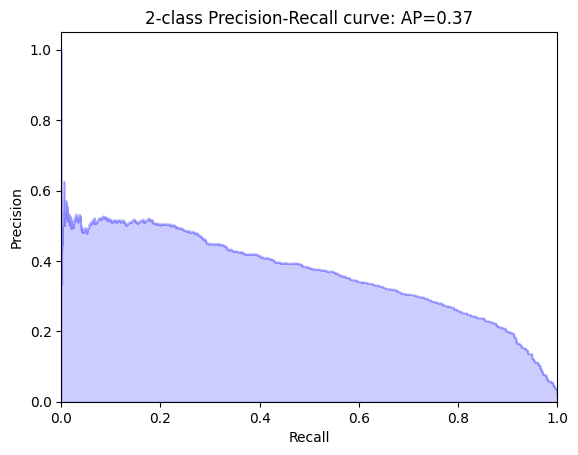

roc auc score: 0.9747510592574177



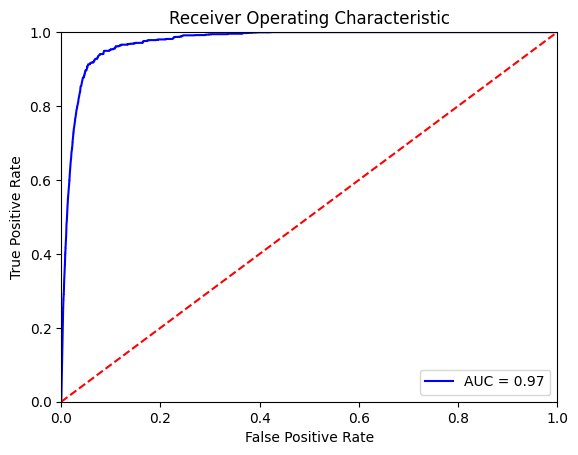

Classification Report: 
               precision    recall  f1-score   support

           0       0.99      0.99      0.99    114191
           1       0.37      0.55      0.44      1618

    accuracy                           0.98    115809
   macro avg       0.68      0.77      0.72    115809
weighted avg       0.98      0.98      0.98    115809


Confusion Matrix: 
 [[112678   1513]
 [   731    887]]



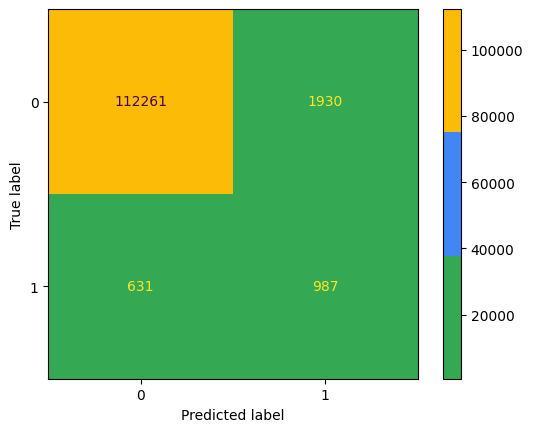

End of validation Result



In [ ]:
# calling the function to get the validation results
clf_score_th(logreg_custom_w, X_train_top, y_train, X_val_top, y_val, train=False, threshold=optimal_threshold)

### Considering F-beta scores

In [ ]:
# calling the function to find the optimal threshold that maximizes the F0.5 score
optimal_threshold_f05, optimal_f05 = find_optimal_threshold(logreg_custom_w, X_train_top, y_train, beta=0.5)
print(f"Optimal Threshold for F0.5: {optimal_threshold_f05:.2f}")
print(f"Optimal F0.5 Score: {optimal_f05:.4f}")

Optimal Threshold for F0.5: 0.76
Optimal F0.5 Score: 0.4134


In [ ]:
# getting the validation results with the optimal threshold for F0.5
clf_score_th(logreg_custom_w, X_train_top, y_train, X_val_top, y_val, train=False, threshold=optimal_threshold_f05)

In [ ]:
# calling the function to find the optimal threshold that maximizes the F2 score
optimal_threshold_f2, optimal_f2 = find_optimal_threshold(logreg_custom_w, X_train_top, y_train, beta=2)
print(f"Optimal Threshold for F2: {optimal_threshold_f2:.2f}")
print(f"Optimal F2 Score: {optimal_f2:.4f}")

Optimal Threshold for F2: 0.31
Optimal F2 Score: 0.5623


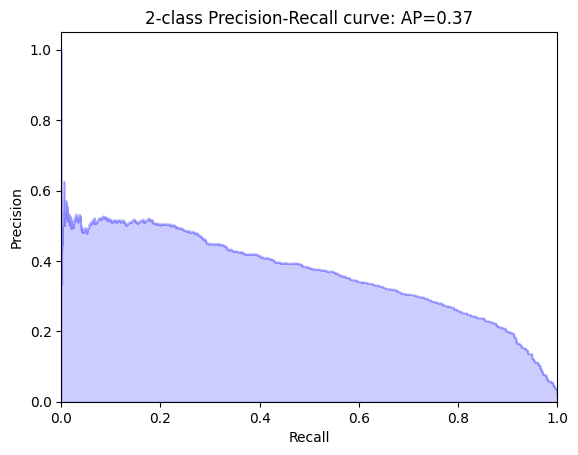

roc auc score: 0.9747510592574177



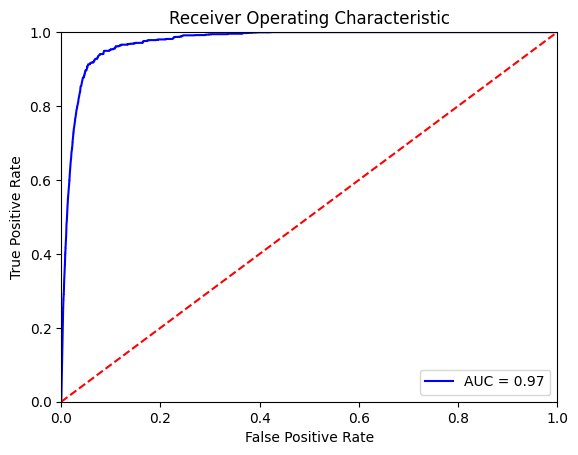

Classification Report: 
               precision    recall  f1-score   support

           0       1.00      0.97      0.98    114191
           1       0.27      0.79      0.40      1618

    accuracy                           0.97    115809
   macro avg       0.63      0.88      0.69    115809
weighted avg       0.99      0.97      0.97    115809


Confusion Matrix: 
 [[110668   3523]
 [   337   1281]]



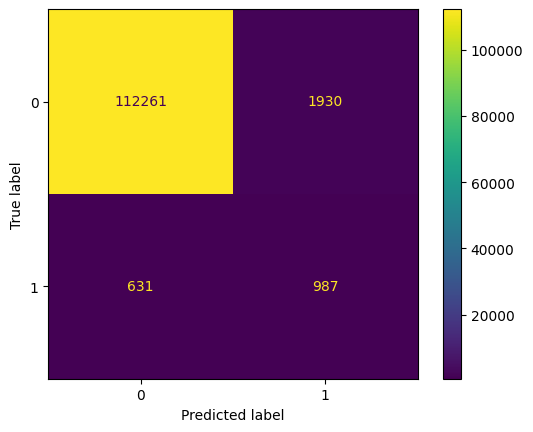

End of validation Result



In [ ]:
# getting the validation results with the optimal threshold for F2
clf_score_th(logreg_custom_w, X_train_top, y_train, X_val_top, y_val, train=False, threshold=optimal_threshold_f2)

### Analyzing the Prediction Errors 

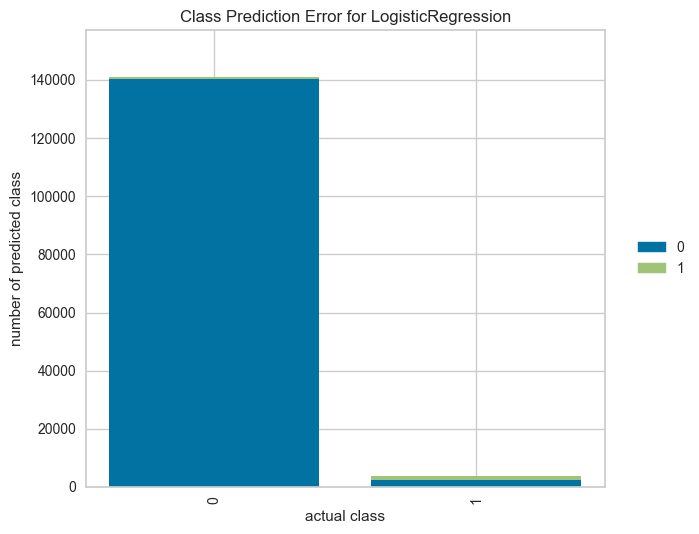

<Axes: title={'center': 'Class Prediction Error for LogisticRegression'}, xlabel='actual class', ylabel='number of predicted class'>

In [ ]:
classes = ["0", "1"]

visualizer = ClassPredictionError(
   logreg_custom_w, classes=classes, is_fitted=True
)

visualizer.fit(X_train_top, y_train)

visualizer.score(X_test[top_features], y_test)

visualizer.show()

### Visualizing the Learning Curve

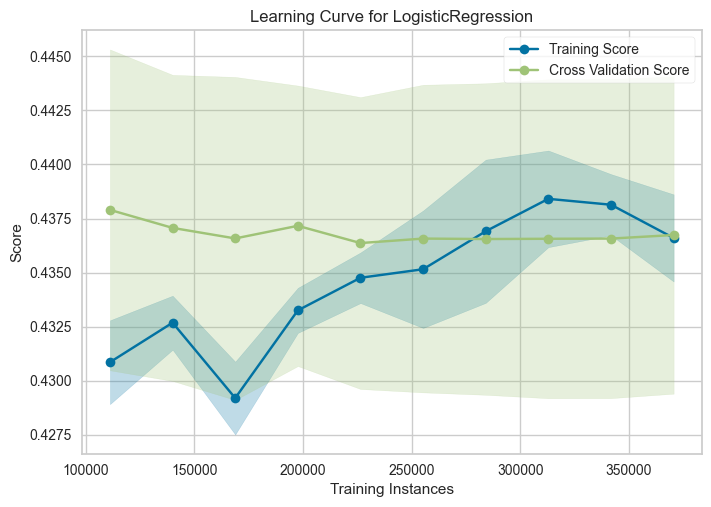

<Axes: title={'center': 'Learning Curve for LogisticRegression'}, xlabel='Training Instances', ylabel='Score'>

In [ ]:
cv = StratifiedKFold(n_splits=5)
sizes = np.linspace(0.3, 1.0, 10)


visualizer = LearningCurve(
    logreg_custom_w, 
    cv=cv, 
    scoring='f1', 
    train_sizes=sizes, 
    n_jobs=8
)

visualizer.fit(X_train_top, y_train)        
visualizer.poof()                       

### Performance on Test Set
- Approximately the same performance on the test set indicating generalizability

In [ ]:
test_df=pd.read_csv('/Users/Abdul/Desktop/MMA/Enterprise Data Science/test_df.csv')

X_test, y_test = preprocess_data(test_df)

In [ ]:
# Performance on the never seen before test set
final_pred=logreg_custom_w.predict(X_test[top_features])
print(classification_report(y_test, final_pred))